In [47]:
import pandas as pd
import matplotlib.pyplot as plt
df_pop = pd.read_csv('pop.csv')
df_sug = pd.read_csv('sugar_per_person_g_per_day.csv')
df_nata = pd.read_csv('children_per_woman_total_fertility.csv')
df_surface = pd.read_csv('surface_area_sq_km.csv')
df_pib = pd.read_csv('gdp_pcap.csv')

# Question 1 :

On va créer une fonction pour gerer les data frame sans traiter un par un:

In [3]:
def filter_rename(df,year,nom_data):
    if str(year) in df.columns :
        df_filtered = df[['country',str(year)]]
        df_filtered = df_filtered.rename(columns={str(year): nom_data})
    return df_filtered

In [4]:
df_pop_2000 = filter_rename(df_pop,2000,'Population')
df_surf_2000 = filter_rename(df_surface,2000,'Surface')
df_fertility_2000 = filter_rename(df_nata,2000,'Fertility')
df_sugre_2000 = filter_rename(df_sug,2000,'Qty Sugar')
df_pib_2000 = filter_rename(df_pib,2000,'Pib')

Maintenant on va Combiner les data filtrés en un seul DataFrame :

In [5]:
df_2000 = df_pop_2000.merge(df_sugre_2000, on='country', how='outer') \
                         .merge(df_fertility_2000, on='country', how='outer') \
                         .merge(df_surf_2000, on='country', how='outer')\
                         .merge(df_pib_2000,on ='country',how ='outer')
df_2000.sort_values(by = 'country')

,country,Population,Qty Sugar,Fertility,Surface,Pib
0,3/1/01,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,20.1M,8.74,7.57,653k,1070
2,Albania,3.17M,63.40,2.22,28.8k,5840
3,Algeria,30.9M,78.60,2.59,2.38M,8580
4,American Samoa,NaN,NaN,NaN,200,NaN
...,...,...,...,...,...,...
218,Virgin Islands (U.S.),NaN,NaN,NaN,350,NaN
219,Yemen,19.6M,64.80,6.32,528k,3880
220,Yugoslavia,NaN,NaN,NaN,NaN,NaN
221,Zambia,10M,44.20,5.92,753k,2000


Remarquant qu'il y'en a une valeur 3/1/01 on doit la supprimer (cette valeur provient de df_2000['Surface'])

In [6]:
df = df_2000.drop(index=[0])
df.head()

,country,Population,Qty Sugar,Fertility,Surface,Pib
1,Afghanistan,20.1M,8.74,7.57,653k,1070
2,Albania,3.17M,63.40,2.22,28.8k,5840
3,Algeria,30.9M,78.60,2.59,2.38M,8580
4,American Samoa,NaN,NaN,NaN,200,NaN
5,Andorra,65.7k,NaN,1.27,470,47k


# Question 2

Pour verifier s'il y a des valeurs manquantes on peut utiliser lafonction pands isnull() avec la fonction sum() pour tirer le nombres des valeurs manquantes pour chaque
Colonne

In [7]:
df.isnull().sum()

country        0
Population    25
Qty Sugar     48
Fertility     25
Surface        8
Pib           27
dtype: int64

Comme on peut le remarquer, oui, il y a des valeurs manquantes, et cela est dû au fait que certains pays n'existent plus depuis l'an 2000, ce qui est normal.

# Question 3 : Variable densité

Pour calculer la densité, nous savons que la densité = Population / Surface. Mais le problème avec notre jeu de données est que dans les colonnes Population et Surface, nous avons des valeurs comme 67,1M et 41,5K, et ces valeurs sont considérées comme des chaînes de caractères. Il est donc nécessaire de les convertir d'abord en nombres flottants afin que nous puissions effectuer nos opérations avec ces données.

In [8]:
df['Surface'] = (df['Surface'].str.replace('M','e6').str.replace('k','e3').str.replace('B','e9').astype(float))
df['Population'] = (df['Population'].str.replace('M','e6').str.replace('k','e3').str.replace('B','e9').astype(float))

Maintenant on fait notre calcul : 

In [9]:
df['Density'] = df['Population'] / df['Surface']
print(df['Density'].head())
print(df['Density'].tail())

1     30.781011
2    110.069444
3     12.983193
4           NaN
5    139.787234
Name: Density, dtype: float64
218          NaN
219    37.121212
220          NaN
221    13.280212
222    30.434783
Name: Density, dtype: float64


In [10]:
print(df['Population'].head())

1    20100000.0
2     3170000.0
3    30900000.0
4           NaN
5       65700.0
Name: Population, dtype: float64


# Question 4

Nous allons calculer pour chacune des variables la moyenne, les 9 déciles, la variance et les deux paramètres de forme.

Nous allons créer des fonctions pour les formules de cours, effectuer nos calculs avec ces fonctions, puis les comparer avec les fonctions déjà existantes dans le module Pandas.

# Fonctions

Fonction Pour la Moyenne : 

In [11]:
def moyenne_cours(data):
    clean_data = [d for d in data if d == d]
    total = 0
    for x in clean_data:
        total += x
    return total/len(clean_data)
    
    

Fonction pour les 9 déciles 

In [12]:
def calculate_deciles_manual(data):
    
    sorted_data = sorted(data)
    n = len(sorted_data)
    deciles = []
    for i in range(1, 10): 
        index = i * n / 10
        if index.is_integer():
            deciles.append(sorted_data[int(index) - 1])
        else:
            lower = int(index) - 1
            upper = lower + 1
            interpolated_value = sorted_data[lower] + (sorted_data[upper] - sorted_data[lower]) * (index - lower - 1)
            deciles.append(interpolated_value)
    
    return deciles

Fonction pour la variance

In [13]:
def variance_cours(dataset) :
    clean_data = [d for d in dataset if d == d]
    length = len(clean_data)
    if length < 2 :
        raise TypeError("Le Dataset doit contenir plus que 2 elements.")
    moyenne = moyenne_cours(clean_data)
    #il nous reste just à implementer notre formule de cours : 
    diff_carre =0
    for x in clean_data:
        diff_carre += (x-moyenne)**2
    return diff_carre/length



Fonction pour calculer l’asymétrie

In [14]:
def asymetrie_cours(dataset):
    #On enleve les Nan :
    clean_data =[v for v in dataset if v == v]
    length = len(clean_data)
    if length< 3 :
        return KeyError
    moyenne = moyenne_cours(dataset)
    variance = variance_cours(dataset)
    ecart_type = variance ** 0.5
    coef_asymetrie = sum(((x-moyenne)/ecart_type)**3 for x in clean_data)/length
    return coef_asymetrie

In [15]:
def aplatissement_cours(dataset):
    clean_data = [v for v in dataset if v == v]
    length = len(clean_data)
    if length < 4:
        return KeyError
    moyenne = moyenne_cours(dataset)
    variance = variance_cours(dataset)
    ecart_type = variance ** 0.5
    coef_aplat = sum(((x-moyenne)/ecart_type) ** 4 for x in clean_data)/length
    return coef_aplat - 3

En comparant les fonctions que nous avons créées et celles de Pandas

PIB : 

In [16]:
df['Pib'] = (df['Pib'].str.replace('M','e6').str.replace('k','e3').str.replace('B','e9').astype(float))

In [17]:
print('Moyenne cours',moyenne_cours(df['Pib'].dropna()))
print('Variance cours',variance_cours(df['Pib']))
print('Coef asymetrie Cours',asymetrie_cours(df['Pib']))
print('Coef applatissement Cours',aplatissement_cours(df['Pib']))
#Pandas : 
print('Moyenne Pandas',df['Pib'].mean())
print('Variance Pandas',df['Pib'].var())
print('Coef asymetrie Pandas',df['Pib'].skew())
print('Coef applatissement Pandas',df['Pib'].kurt())

Moyenne cours 15550.851282051282
Variance cours 398505942.78301096
Coef asymetrie Cours 2.641564749471381
Coef applatissement Cours 9.867791338549118
Moyenne Pandas 15550.851282051282
Variance Pandas 400560097.1272533
Coef asymetrie Pandas 2.662086249252113
Coef applatissement Pandas 10.156975870493065


Fertilité : 

In [18]:
print('Moyenne cours',moyenne_cours(df['Fertility']))
print('Variance cours',variance_cours(df['Fertility']))
print('Coef asymetrie Cours',asymetrie_cours(df['Fertility']))
print('Coef applatissement Cours',aplatissement_cours(df['Fertility']))
#Pandas : 
print('Moyenne Pandas',df['Fertility'].mean())
print('Variance Pandas',df['Fertility'].var())
print('Coef asymetrie Pandas',df['Fertility'].skew())
print('Coef applatissement Pandas',df['Fertility'].kurt())

Moyenne cours 3.265939086294416
Variance cours 3.084713458218458
Coef asymetrie Cours 0.7080411960695823
Coef applatissement Cours -0.6348721599101625
Moyenne Pandas 3.265939086294416
Variance Pandas 3.1004517921889603
Coef asymetrie Pandas 0.7134853570208128
Coef applatissement Pandas -0.6201987518317047


Quantité Sucre : 

In [19]:
print('Moyenne cours',moyenne_cours(df['Qty Sugar']))
print('Variance cours',variance_cours(df['Qty Sugar']))
print('Coef asymetrie Cours',asymetrie_cours(df['Qty Sugar']))
print('Coef applatissement Cours',aplatissement_cours(df['Qty Sugar']))
#Pandas : 
print('Moyenne Pandas',df['Qty Sugar'].mean())
print('Variance Pandas',df['Qty Sugar'].var())
print('Coef asymetrie Pandas',df['Qty Sugar'].skew())
print('Coef applatissement Pandas',df['Qty Sugar'].kurt())

Moyenne cours 80.27103448275862
Variance cours 1926.5225506539848
Coef asymetrie Cours 0.09051879245158016
Coef applatissement Cours -0.8321373942870349
Moyenne Pandas 80.27103448275862
Variance Pandas 1937.6585191548747
Coef asymetrie Pandas 0.09130782136596181
Coef applatissement Pandas -0.8212620567129032


Surface : 

In [20]:
print('Moyenne cours',moyenne_cours(df['Surface']))
print('Variance cours',variance_cours(df['Surface']))
print('Coef asymetrie Cours',asymetrie_cours(df['Surface']))
print('Coef applatissement Cours',aplatissement_cours(df['Surface']))
#Pandas : 
print('Moyenne Pandas',df['Surface'].mean())
print('Variance Pandas',df['Surface'].var())
print('Coef asymetrie Pandas',df['Surface'].skew())
print('Coef applatissement Pandas',df['Surface'].kurt())

Moyenne cours 625994.8412616822
Variance cours 3351641701852.601
Coef asymetrie Cours 5.787834501979326
Coef applatissement Cours 38.81829357528385
Moyenne Pandas 625994.8412616822
Variance Pandas 3367377108903.5522
Coef asymetrie Pandas 5.828770176915341
Coef applatissement Pandas 39.76933189394891


Population : 

In [21]:
print('Moyenne cours',moyenne_cours(df['Population']))
print('Variance cours',variance_cours(df['Population']))
print('Coef asymetrie Cours',asymetrie_cours(df['Population']))
print('Coef applatissement Cours',aplatissement_cours(df['Population']))
#Pandas : 
print('Moyenne Pandas',df['Population'].mean())
print('Variance Pandas',df['Population'].var())
print('Coef asymetrie Pandas',df['Population'].skew())
print('Coef applatissement Pandas',df['Population'].kurt())

Moyenne cours 31289588.92893401
Variance cours 1.4693181808036664e+16
Coef asymetrie Cours 8.602772129580647
Coef applatissement Cours 78.83746982059498
Moyenne Pandas 31289588.92893401
Variance Pandas 1.4768147021342974e+16
Coef asymetrie Pandas 8.668919235653261
Coef applatissement Pandas 80.9067017921664


# Question 5

C:\Users\maysttro\AppData\Local\Temp\ipykernel_2856\3685031701.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_by_gdp = gdp.groupby(fertility_classes).apply(list)


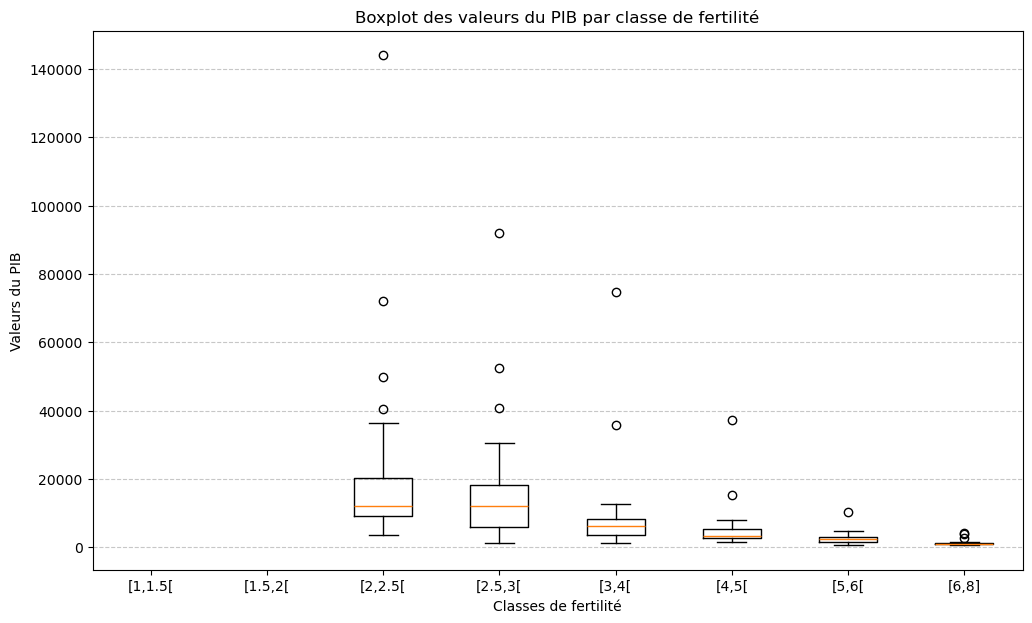

In [61]:
#On va creer les Bins et Labels :
Bins1 = [1,1.5,2,2.5,3,4,5,6,8]
labels = ['[1,1.5[','[1.5,2[','[2,2.5[','[2.5,3[','[3,4[','[4,5[','[5,6[','[6,8]']
fertility = df['Fertility']

# Classify fertility values into bins
fertility_classes = pd.cut(fertility, bins=Bins1, labels=labels, right=False)
gdp = df['Pib']
group_by_gdp = gdp.groupby(fertility_classes).apply(list)


# Create the boxplot
plt.figure(figsize=(12, 7))
plt.boxplot(group_by_gdp, labels=group_by_gdp.index, patch_artist=False)

# Customize the plot
plt.xlabel("Classes de fertilité")
plt.ylabel("Valeurs du PIB")
plt.title("Boxplot des valeurs du PIB par classe de fertilité")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

In [23]:
print(fertility_classes)

Fertility
[1,1.5[    31
[1.5,2[    31
[2,2.5[    25
[2.5,3[    23
[3,4[      25
[4,5[      21
[5,6[      25
[6,8]      16
Name: count, dtype: int64


In [24]:
import matplotlib.pyplot as plt

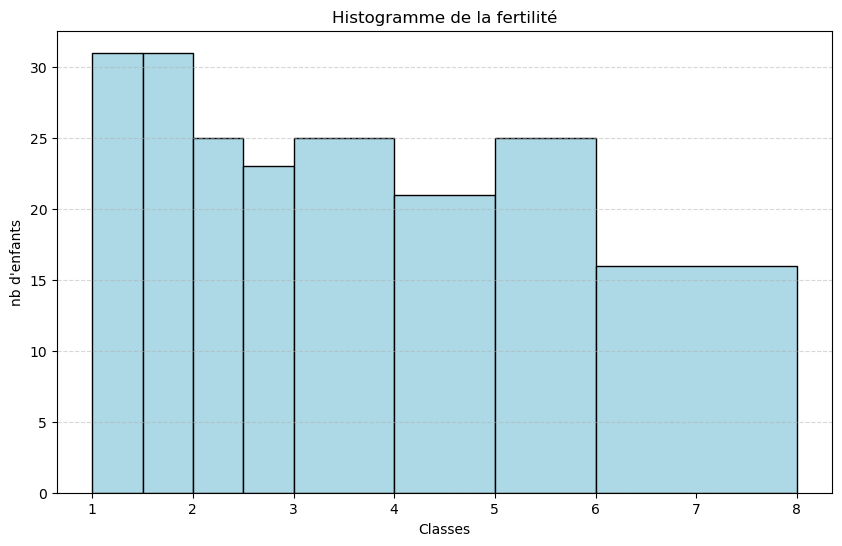

In [25]:

plt.figure(figsize = (10,6))
plt.hist(df['Fertility'], bins = Bins1 , color='lightblue', edgecolor='black')
plt.title("Histogramme de la fertilité")
plt.xlabel("Classes")
plt.ylabel("nb d'enfants")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


# Question 6 : 

Entre 1 et 2 : 

<Axes: >

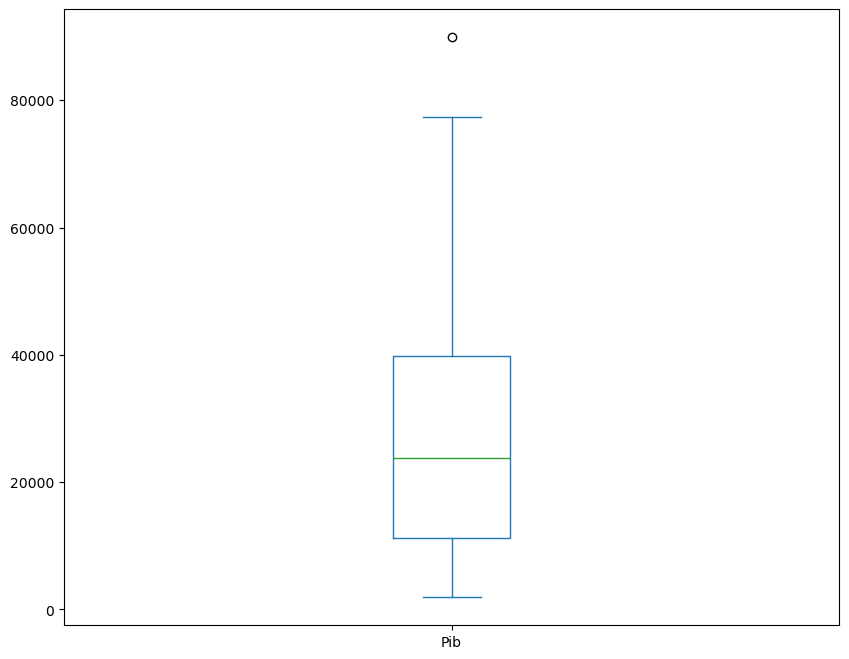

In [26]:
classe_1_2 = df[(df['Fertility']>=1)&(df['Fertility']<2)]
classe_1_2['Pib'].plot(kind= 'box',figsize = (10,8))

Entre 2 et 3 :

<Axes: >

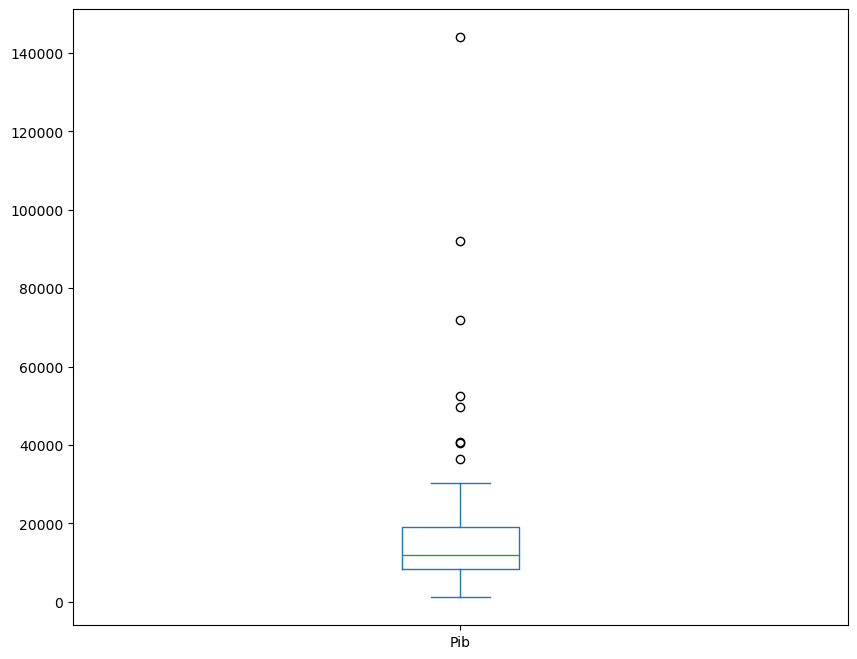

In [27]:
classe_2_3 = df[(df['Fertility']>=2)&(df['Fertility']<3)]
classe_2_3['Pib'].plot(kind= 'box',figsize = (10,8))

Entre 3 et 4 :

<Axes: >

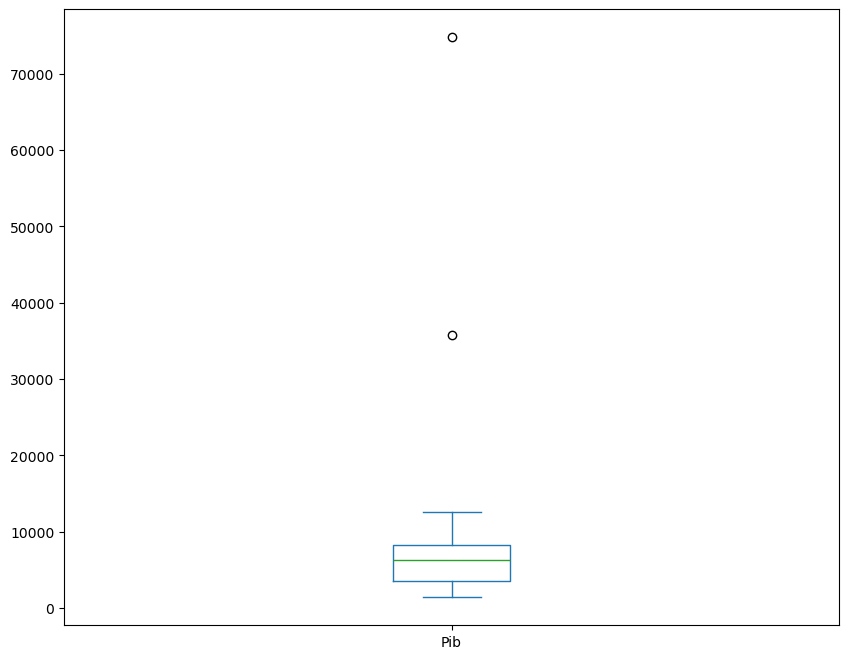

In [28]:
classe_3_4 = df[(df['Fertility']>=3)&(df['Fertility']<4)]
classe_3_4['Pib'].plot(kind= 'box',figsize = (10,8))

Entre 4 et 6 :

<Axes: >

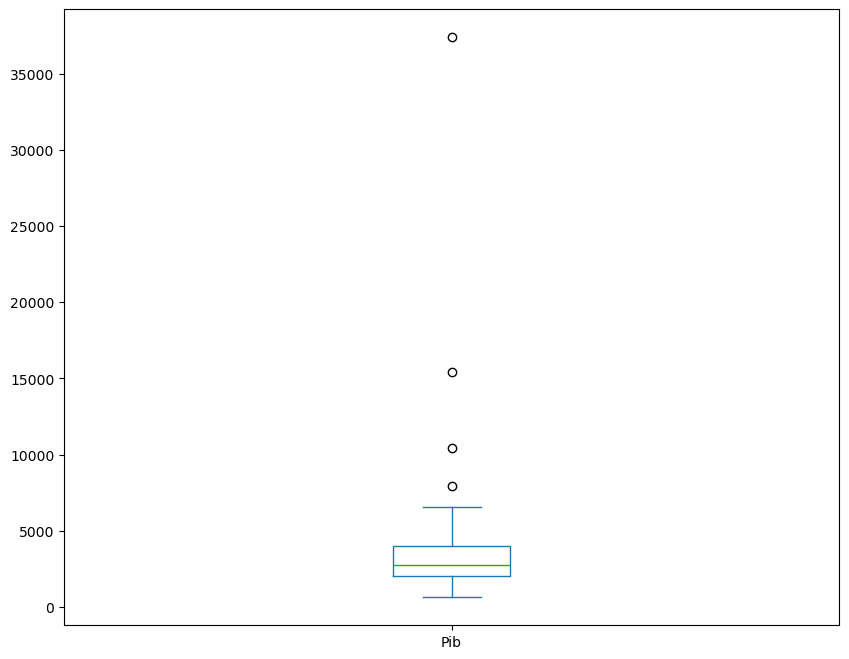

In [29]:
classe_4_6 = df[(df['Fertility']>=4)&(df['Fertility']<6)]
classe_4_6['Pib'].plot(kind= 'box',figsize = (10,8))

<Axes: >

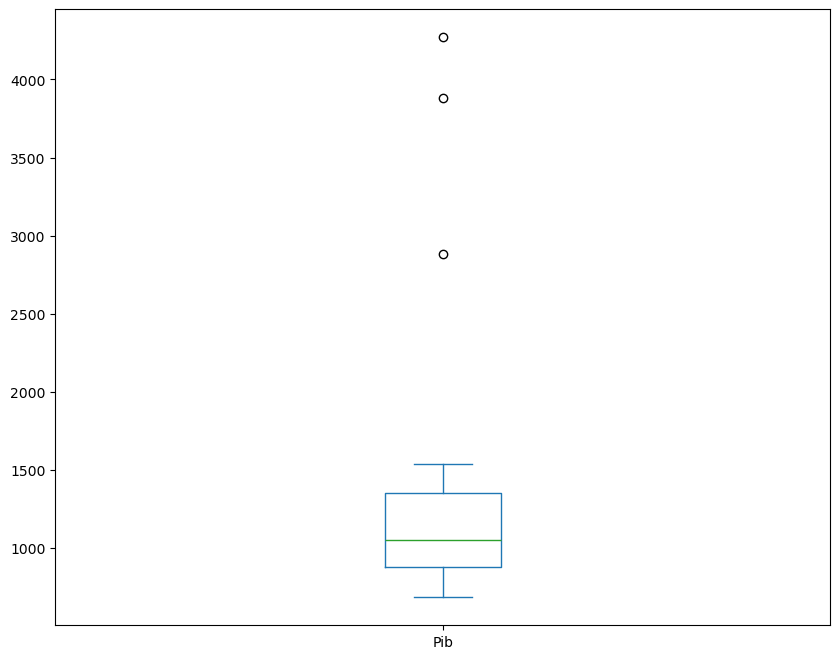

In [54]:
classe_6_8 = df[(df['Fertility']>=6)&(df['Fertility']<=8)]
classe_6_8['Pib'].plot(kind= 'box',figsize = (10,8))

# Qestion 7 la quantité de sucre consommé en 2000, par personne et par jour, au niveau mondial.

In [31]:
sucre_population = df['Population'] * df['Qty Sugar']
total_sucre_population = sucre_population.sum()
quantite_consomme = total_sucre_population / df['Population'].sum()
print(quantite_consomme)

64.52042067058714


# Question 8 

In [32]:
#Soit X = "Pib" et Y = "nb moyen d'enfants par femme" on commence par calculer la covariance
Pib = df['Pib'].dropna()
enf = df['Fertility'].dropna()
mean_pib = moyenne_cours(Pib)
mean_enf = moyenne_cours(enf)
ecart1 = Pib - mean_pib
ecart2 = enf -mean_enf
produit = ecart1 * ecart2
cov = produit.sum() / len(Pib)
ecart_pib = variance_cours(Pib)**0.5
ecart_enf = variance_cours(enf)**0.5
corr = cov/(ecart_pib * ecart_enf)
print('Correlation en utilisant la formule de Cours',corr)
print('Correlation en utilisant la fonction de Pandas',Pib.corr(enf))

Correlation en utilisant la formule de Cours -0.47325658219846495
Correlation en utilisant la fonction de Pandas -0.4740143879398797


Un coefficient de -0.473 entre le PIB et la fertilité indique qu'il existe une relation inverse modérée : en général, dans les pays avec un PIB plus élevé, la fertilité tend à être plus faible. Cependant, cette relation n'est pas parfaite, ce qui suggère qu'il existe d'autres facteurs qui influencent également les taux de fertilité.

# Carte choroplèthe : 

In [33]:
import geopandas as geopd
monde = geopd.read_file('pays.geo.json')
monde_test = geopd.read_file('pays.geo.json')
sucre = df[['country','Qty Sugar']]
sucre = sucre.rename(columns={'country': 'admin', 'Qty Sugar': 'conso_sucre'})

In [34]:
merge = monde.merge(sucre,on = 'admin',how = 'left')

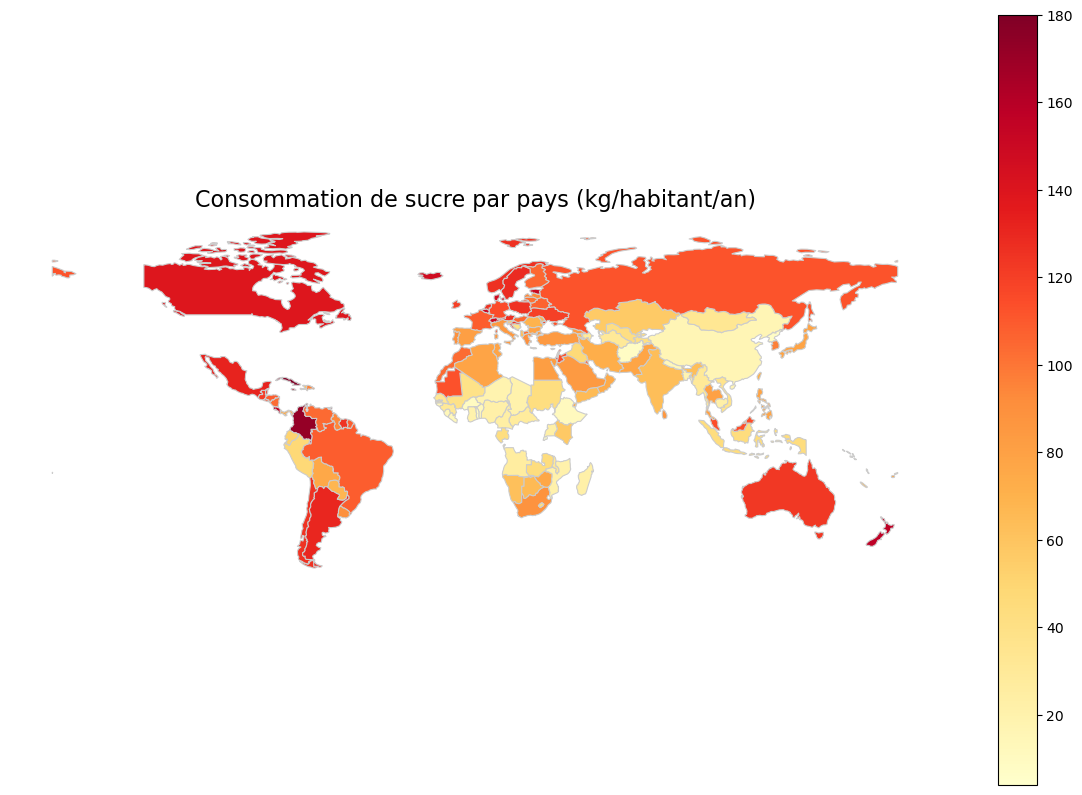

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
merge.plot(column='conso_sucre',  # Colonne avec les données de sucre
            cmap='YlOrRd',  # Palette de couleurs
            linewidth=0.8,
            ax=ax,
            edgecolor='0.8',
            legend=True)

# 5. Ajouter un titre et ajuster l'affichage
ax.set_title("Consommation de sucre par pays (kg/habitant/an)", fontsize=16)
ax.axis("off")  # Supprime les axes

# Afficher la carte
plt.show()

En remarquant, il nous manque certains pays, comme les États-Unis, et c'est normal car, lors du merge de nos données, le nom du pays dans la colonne 'sucre' est différent de celui du fichier JSON. Nous allons donc créer une fonction qui attribuera à chaque pays un code ISO, et nous fusionnerons les deux DataFrames sur ce code ISO.

In [36]:
sucre = sucre.rename(columns={'country' : 'sovereignt'})


In [37]:
sucre.head()

,admin,conso_sucre
1,Afghanistan,8.74
2,Albania,63.40
3,Algeria,78.60
4,American Samoa,NaN
5,Andorra,NaN


Nous allons importer la bibliothèque pycountry qui effectue ce travail et nous l'appliquerons aux deux jeux de données. (Si vous ne l'avez pas, monsieur, vous pouvez taper cette commande : pip install pycountry.)

In [38]:
import pycountry

In [39]:
def get_iso_alpha_3(country_name):
    try:
        return pycountry.countries.lookup(country_name).alpha_3
    except LookupError:
        return None

# Appliquer la conversion
sucre['ISO3'] = sucre['admin'].apply(get_iso_alpha_3)
monde_test['ISO3'] = monde_test['sovereignt'].apply(get_iso_alpha_3)

In [40]:
merged_df = monde_test.merge(sucre, on='ISO3', how='left')

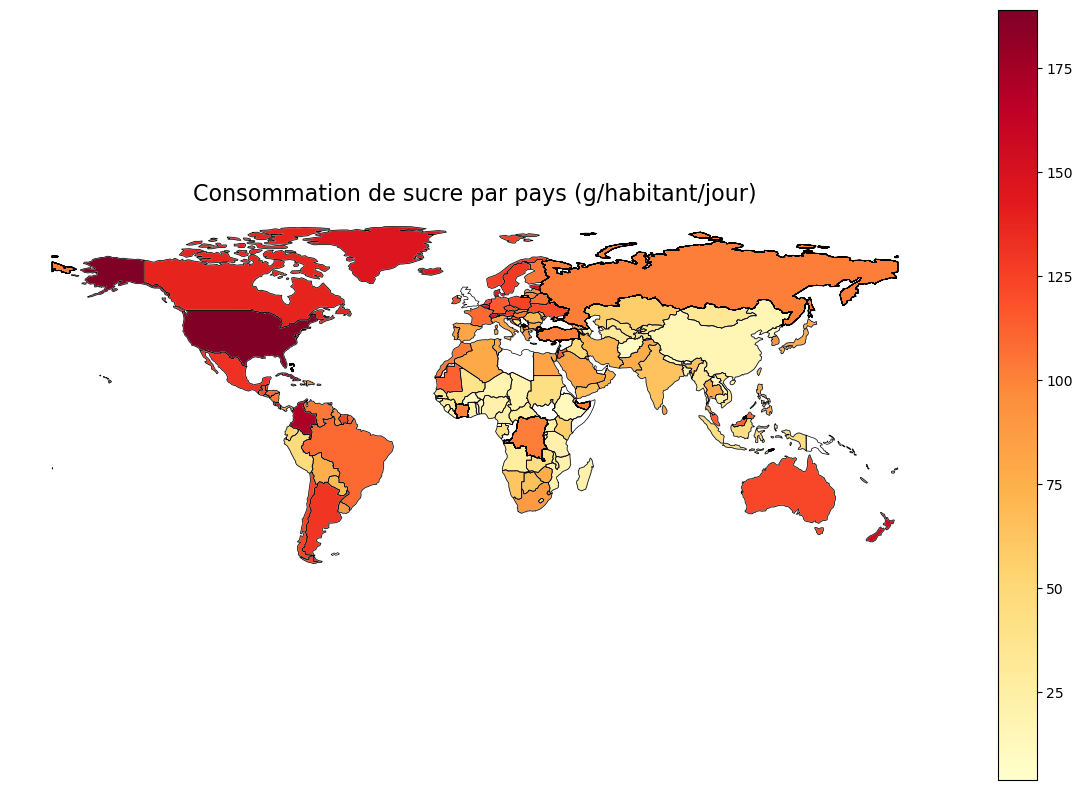

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
merged_df.plot(column='conso_sucre',  # Colonne avec les données de sucre
            cmap='YlOrRd',  # Palette de couleurs
            linewidth=0.8,
            ax=ax,
            edgecolor='0.8',
            legend=True)

merged_df.boundary.plot(ax=ax, linewidth=0.5, color='black')  # Ajouter les frontières

ax.set_title("Consommation de sucre par pays (g/habitant/jour)", fontsize=16)
ax.set_facecolor('lightgray')
ax.set_axis_off()

# Afficher la carte
plt.show()